In [1]:
from genericpath import exists
import sys
import os
from pathlib import Path
from typing import Tuple
from typing import List
from typing import Generator
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from common import get_grid
from common import LIST_CYCLE_POSITION_SHIFT
from common import Grid
from solution_bfs_bounded import bfs_spiral_add_numbers_to_grid_bounded
from solution_bfs_unbounded import bfs_spiral_add_numbers_to_grid_unbounded
from solution_math import math_solution_add_numbers_to_grid_independent_of_grid

from utility import GridRecordable

# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(linewidth=sys.maxsize)

NAME_DIRETORY_MEIDA_OUTPUT = "media"
PATH_DIRETORY_MEIDA_OUTPUT_ABSOLUTE = Path("", NAME_DIRETORY_MEIDA_OUTPUT)
PATH_DIRETORY_MEIDA_OUTPUT_ABSOLUTE.mkdir(parents=True, exist_ok=True)
print(f"Media Output directory: {PATH_DIRETORY_MEIDA_OUTPUT_ABSOLUTE}")

Media Output directory: media


In [2]:
def display_solution(matrix, figsize=(10,10)):
    # Get the shape of the matrix
    num_rows, num_cols = matrix.shape

    # Create a meshgrid for X and Y
    np_array_x = np.arange(0, num_cols, 1)
    np_array_y = np.arange(0, num_rows, 1)
    np_array_2d_x, np_array_2d_y = np.meshgrid(np_array_x, np_array_y)

    # Create a 3D plot
    figure_1 = plt.figure(figsize=figsize)
    axes_1 = figure_1.add_subplot(111, projection='3d')

    # Add labels
    axes_1.set_xlabel('X-axis')
    axes_1.set_ylabel('Y-axis')
    axes_1.set_zlabel('Height')

    # Plot the 3D surface
    axes_1.plot_surface(np_array_2d_x, np_array_2d_y, matrix, cmap='viridis')
    
    ####################
    
    figure_2 = plt.figure(figsize=figsize)
    axes_2 = figure_2.add_subplot(111)
    
    image = axes_2.imshow(matrix, cmap='viridis', origin='lower')
    colorbar = figure_2.colorbar(image, ax=axes_2)  # Add colorbar to the subplot

    axes_2.set_title('Height Matrix')
    axes_2.set_xlabel('X-axis')
    axes_2.set_ylabel('Y-axis')
    
    ####################
    
    # Calculate the gradient using np.gradient
    gradient_y, gradient_x = np.gradient(matrix)

    # Create a vector field
    vector_field_x = -gradient_x
    vector_field_y = -gradient_y
    
    figure_3 = plt.figure(figsize=figsize)
    axes_3 = figure_3.add_subplot(111)

    axes_3.quiver(vector_field_x, vector_field_y, scale=20, scale_units='xy', angles='xy')
    axes_3.set_title('Vector Field (Gradient)')
    axes_3.set_xlabel('X-axis')
    axes_3.set_ylabel('Y-axis')

        

In [3]:
from typing import Dict, Hashable
from collections import defaultdict

from IPython.display import HTML, Image, display, Markdown

import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.artist import Artist
from matplotlib.image import AxesImage

"""

Notes:

    Running the code below and then calling IPython.display.Image(animation_1.to_jshtml()) 
        
        Draw all all text_number
            Runtime on 100 frames, interval=10, No saving:
                ~1 minute 7 seconds
            
            Runtime on 625 frames, interval=10, No saving:
                ~7 minutes 30 seconds
                
        Draw cumulative artist_text_number 

            Runtime on 100 frames, interval=10, No saving:
                ~20 seconds
                
            Runtime on 625 frames, interval=10, No saving:
                ~4 minutes 50 seconds

        Draw on the same artist matrix as the previous frame if it exists
            Runtime on 100 frames, interval=10, No saving:
                ~48 seconds
                
            Runtime on 625 frames, interval=10, No saving:
                5 minutes 40 seconds

"""

"""
1000 MB memory limit when making a matplotlib Animation. 

IMPORTANT NOTES:
    IF YOU MAKE

Refernece:
    Matplotlib: Set the animation.rc parameter
        Notes:
            "
            Animation size has reached 20997590 bytes, exceeding the limit of 20971520.0. 
            If you're sure you want a larger animation embedded, set the animation.embed_limit 
            rc parameter to a larger value (in MB). This and further frames will be dropped.
            "
        Reference:
            https://stackoverflow.com/questions/52778505/ma
"""
matplotlib.rcParams['animation.embed_limit'] = 1000 



def get_animation_of_matrix_changes(list_matrix: List[np.ndarray], path_abs_filename:Union[str, None] =None) -> FuncAnimation:
    """
    
    IMPORTANT NOTES:
        RUNNING THIS FUNCTION TAKES FOREVER
        
    Notes:
        Do not use a generator to pull a matrix from list_matrix because
        the generator will throw a StopInteration because update(index_frame) 
        will be called multiple times which will be more than the side of the generator.
        Instead, use the index_frame in the update function to get the correct matrix based on index.
        
    Reference:
        How do I close figure in matplotlib?
            Notes:
                Using 
                    from IPython.display import clear_output
                    clear_output()
                only clears text, not matplotlib figures
                
                Use plt.close(figure) instead
                
            Reference:
                https://stackoverflow.com/a/73665280
                
                
        matplotlib.animation.FuncAnimation
            Notes:
                func: callable
                    "
                    If blit == True, func must return an iterable of all artists that were MODIFIED or CREATED. 
                    This information is used by the blitting algorithm to determine which parts of the figure have to be updated. 
                    The return value is unused if blit == False and may be omitted in that case.
                    "
                    
                    So, to be efficient, only add artists that are new or modified ASSUMING YOU DON'T CALL axes.clear() 
                    
            Reference:
                https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.htmlc

    """

    # Create a figure and axes
    figure = plt.figure(figsize=(10,10))
    axes = figure.add_subplot(111)
    
    value_max_in_matrix_last = 0
    value_min_in_matrix_last = 0
    
    
    if list_matrix:
        matrix = list_matrix[-1]
        
        value_max_in_matrix_last = np.amax(matrix)
        value_min_in_matrix_last = np.amin(matrix)
        
    ##################################################
    
    list_np_ndarray_cumulative_change: List[np.ndarray] = []
    
    for matrix in list_matrix:
        np_ndarray_indices = np.column_stack(np.where(matrix > 0))

        list_np_ndarray_cumulative_change.append(np_ndarray_indices)
    
    
    ##################################################
    
    list_np_ndarray_difference: List[np.ndarray] = []
        
    if list_matrix:
        
        """
        Getting all the indices of the first matrix
        Notes:
            The code below is good because it makes the logical difference
            between no matrix and list_matrix[0] which is just list_matrix[0]
        """
        np_ndarray_differnce = np.indices(list_matrix[0].shape).reshape(2, -1).T
        
        """
        Getting all the indices of the first matrix whose element is > 0
        Notes:
            The code below is bad if you assume that values in the matrix are greater
            than 0. This makes the code not a general solution.
        """
        # np_ndarray_differnce = np.column_stack(np.where(list_matrix[0] > 0))
            
        list_np_ndarray_difference.append(np_ndarray_differnce)
        
        for index in range(1, len(list_matrix)):
        
            # Find cells with different values
            different_values = list_matrix[index] != list_matrix[index-1]

            # Get indices of cells with different values
            np_ndarray_differnce = np.column_stack(np.where(different_values))
            
            list_np_ndarray_difference.append(np_ndarray_differnce)
    
    
    ##################################################
    
    _dict_k_key_v_artist: Dict[Hashable, Union[Artist, None]] = defaultdict(lambda: None) 
    
    # Function to update the plot for each frame
    def update(index_frame):
        
        nonlocal _dict_k_key_v_artist
        """
        If you are calling axes.imshow() or adding artists that overwrite
        previous artists but are not the same artist, then you need to call
        axes.clear()
        
        Also, not calling axes.clear() will break the HTML animation, but
        will not affect the .gif
        
        """
        # axes.clear() 
        
        matrix = list_matrix[index_frame]

        
        _list_artist = []

        """
        ##################################################
        Draw all all text_number
        (Use this when axes.clear() is called)
        
        Notes:
            This will draw all the elements for
            the matrix.  
            
        ##################################################
        """
        
        # # Display the numbers in the matrix
        # for i in range(matrix.shape[0]):
        #     for j in range(matrix.shape[1]):
        #         text_number = axes.text(j, i, f'{matrix[i, j]}', ha='center', va='center', color='white')
        #         _list_artist.append(text_number)
        
        
        """
        ##################################################
        Draw cumulative artist_text_number 
        (Use this when axes.clear() is called)
        
        Notes:
            np_ndarray_cumulative_change contains np ndarrays
            that are the indices of elements of the matrix
            that contain all the changes since the first matrix.
            Basically, a following np_ndarray_cumulative_change
            contains all the indices of the all the previous
            np ndarrays which is why it
            cumulatively contains changes.
            
            Assuming axes.clear() WAS CALLED BEFORE THE BELOW CODE,
            then the below code would be efficient because it would only
            create the new artits that needs to be drawn and added at
            this time. In this case, artist_text_number is the new
            artist and it is added to _list_artist
            
            Obviously, it's not as efficient as drawing only the 
            new changes based on the previous frame, but since
            axes.clear() WAS CALLED, this is the most efficient
            process you can do.
                
        ##################################################
        """
        # nonlocal list_np_ndarray_cumulative_change
        
        # np_ndarray_cumulative_change = list_np_ndarray_cumulative_change[index_frame]
        
        # for np_ndarray_coordinate in np_ndarray_cumulative_change:
        #     artist_text_number = axes.text(
        #         np_ndarray_coordinate[1],  # The origin for matplotlib is bottom left
        #         np_ndarray_coordinate[0],  # The origin for matplotlib is bottom left
        #         f'{matrix[np_ndarray_coordinate[0], np_ndarray_coordinate[1]]}',  # The origin for numpy is top left
        #         ha='center', va='center', color='white'
        #     )
            
        #     _list_artist.append(artist_text_number)

        """
        ##################################################
        Draw on existing artist_text_number or draw new artist_text_number
        (Use this when axes.clear() is not called)
        
        Notes:
            The np ndarrays in np_ndarray_difference
            are the indices of elements of the matrix
            that are different from the previous frame's matrix.
            Basically, np_ndarray_difference most likely contains an 
            ndarray that contains 1 pair of indices that represents 
            1 element.
            
            Assuming axes.clear() WAS NOT CALLED BEFORE THE BELOW CODE, 
            then using the below code would be efficient because it would only 
            create NEW arists, in this case, the artist would be text_number. 
            This new artist is then added to _list_artist.
                
        ##################################################
        """
        nonlocal list_np_ndarray_difference
        
        np_ndarray_difference = list_np_ndarray_difference[index_frame]
        
        for np_ndarray_coordinate in np_ndarray_difference:
            
            _key = (np_ndarray_coordinate[0], np_ndarray_coordinate[1])
            
            if _dict_k_key_v_artist[_key] is None:    
                artist_text_number = axes.text(
                    np_ndarray_coordinate[1],
                    np_ndarray_coordinate[0], 
                    f'{matrix[np_ndarray_coordinate[0], np_ndarray_coordinate[1]]}', 
                    ha='center', va='center', color='white'
                )
                _dict_k_key_v_artist[_key] = artist_text_number
            
            _dict_k_key_v_artist[_key].set(
                x=np_ndarray_coordinate[1],
                y=np_ndarray_coordinate[0], 
                text=f'{matrix[np_ndarray_coordinate[0], np_ndarray_coordinate[1]]}', 
                ha='center', va='center', color='white'
            )
            
            
            _list_artist.append(_dict_k_key_v_artist[_key])  
                
        """
        ##################################################
        Draw on the same artist matrix as the previous frame if it exists
        otherwise draw a new arist matrix.
        (Use this when axes.clear() is not called)
        
        Notes:
            Draw the artist matrix once, then refer to the same
            artist matrix when modified for blit to run efficiently.
            
            The matrix changes every frame, so there is no
            need for a conditional to check if matrix changes.
            
            *** If you call axes.clear() you must make a new
            image via axes.imshow(...) which will automatically be
            added to the hidden list of artists.
            Though, you should still add it to _list_artist
            
            kwargs for axes.imshow(...)
                vmin this specifies the color range lowest value
                vmax this specifies the color range highest value
                
        ##################################################
        """
        if _dict_k_key_v_artist["_artist_matrix"] is None:
            _dict_k_key_v_artist["_artist_matrix"] = axes.imshow(
                matrix, 
                cmap='viridis',
                vmin=value_min_in_matrix_last,  # This sets the color range lowest value
                vmax=value_max_in_matrix_last,  # This will set the color range highest value 
            )
        
        _dict_k_key_v_artist["_artist_matrix"].set_array(matrix)
        _list_artist.append(_dict_k_key_v_artist["_artist_matrix"])

        
        """
        ##################################################
        Draw a new matrix every frame
        (Use this when axes.clear() is called)
        
        Notes:
            * Drawing a new matrix adjusts the color range based on the existing 
            values in the matrix.
            
            *** Calling axes.imshow will automatically add the image from axes.imshow 
            to the hidden list of artists, so I don't think you need to 
            add it to _list_artist but you should still add it to that list.
            
            You must call axes.clear() or the full matrix will be drawn
            along with the previous matrices drawn.
            
        IMPORTANT NOTES:
            If the kwargs vmin and and vmax for axes.imshow(...) are set,
            then .gif files won't be too big. If both vmin and vmax are
            commented out, then the colors of the .gif will change as 
            the animation runs which would make the.gif file large ranging 
            from 1 MB to 12 MB or higher.
            
        ##################################################
        """            
        # _figure_matrix = axes.imshow(
        #     matrix, 
        #     cmap='viridis',
        #     vmin=value_min_in_matrix_last,  # This sets the color range lowest value
        #     vmax=value_max_in_matrix_last,  # This will set the color range highest value 
        # )
                
        # _list_artist.append(_figure_matrix)
        
        
        """
        ##################################################
        Draw on the same title
        (Use this when axes.clear() is not called)
        
        Notes:
            Draw the artist title once, then refer to the same
            artist title when modified for blit to run efficiently.
        
            The title changes every frame, so there is no
            need for a conditional to check if title changes.
            
        ##################################################
        """
        if _dict_k_key_v_artist["_artist_title"] is None:
            _dict_k_key_v_artist["_artist_title"] = axes.set_title(f"Frame index: {index_frame}") 
                
        _dict_k_key_v_artist["_artist_title"].set_text(f"Frame index: {index_frame}")
        _list_artist.append(_dict_k_key_v_artist["_artist_title"])
            
        """
        ##################################################
        Draw a new title
        (Use this when axes.clear() is called)
        
        Notes:
            Use the below code if axes.clear() is called
            otherwise you will be inefficiently drawing over
            previous titles.
        ##################################################
        """
        
        # text_title = axes.set_title(f"Frame {index_frame}")
        # _list_artist.append(text_title)
        
        
        ##################################################
        
        # print(type(_image))
        # print(type(a))
        
        # print(index_frame)
        # print(matrix)
        # print()
        
        # print(len(_list_artist))
        return _list_artist
        # return tuple()
        
    # Create the animation
    animation = FuncAnimation(
        figure, 
        update, 
        frames=len(list_matrix), 
        interval=10,
        blit=True,
    )
    
    if path_abs_filename is not None:
        if not Path(path_abs_filename).exists():
            print(f"Saving to {path_abs_filename}")
            """
            The animation speed is set by the "interval" parameter of FuncAnimation, however, if the "interval" parameter
            is too low, the file saved won't go any lower.
            """
            animation.save(
                path_abs_filename,
                # fps=100,  # Setting FPS won't make the animation faster even if the interval from FuncAnimation is very low.
                )
        else:
            print(f"{path_abs_filename} already exists! No file saved!")
        
    # Clear the IPython (Jupyter) html
    # clear_output()
    
    # Close the figure created above because you only care about the animation
    plt.close(figure)
    
    # The below does not work in a function. It only works ub jupyter cell where the line of code is on the global level and not in any code body.
    # HTML(animation.to_jshtml())  
    return animation

# Initial data

In [4]:
list_cycle_position_shift = LIST_CYCLE_POSITION_SHIFT

grid_size_x = 25
grid_size_y = 25

position_center_absolute: Tuple[int, int] = (15, 10)


# Solution 1 (BFS add numbers to grid but bounded by the grid)

In [5]:
grid_recordable_1 = GridRecordable((grid_size_x, grid_size_y))

bfs_spiral_add_numbers_to_grid_bounded(
    grid_recordable_1, 
    position_center_absolute, 
    list_cycle_position_shift
)
    
matrix_1 = np.array(grid_recordable_1)
print(matrix_1)

[[625 600 552 506 462 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420]
 [624 599 551 505 461 400 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361]
 [623 598 550 504 460 399 342 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290]
 [622 597 549 503 459 398 341 272 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 291]
 [621 596 548 502 458 397 340 271 210 157 158 159 160 161 162 163 164 165 166 167 168 169 170 227 292]
 [620 595 547 501 457 396 339 270 209 156 111 112 113 114 115 116 117 118 119 120 121 122 171 228 293]
 [619 594 546 500 456 395 338 269 208 155 110  73  74  75  76  77  78  79  80  81  82 123 172 229 294]
 [618 593 545 499 455 394 337 268 207 154 109  72  43  44  45  46  47  48  49  50  83 124 173 230 295]
 [617 592 544 498 454 393 336 267 206 153 108  71  42  21  22  23  24  25  26  51  84 125 174 231 296]
 [616 591 543 497 453 392 335 266 205 152 107  70  41  20   7   8   9  10

In [6]:
list_matrix_1 = grid_recordable_1.get_list_matrix_recorded()
list_matrix_1 = list_matrix_1 # Leave this here for debugging via slicing

STR_PATH_FILENAME_SOLUTION_1 = str(Path(PATH_DIRETORY_MEIDA_OUTPUT_ABSOLUTE, "solution_1.gif"))

animation_1 = get_animation_of_matrix_changes(
    list_matrix_1,
    STR_PATH_FILENAME_SOLUTION_1,  
)

media\solution_1.gif already exists! No file saved!


In [7]:
# IF THIS IS DISPLAYED AND THIS FILE IS SAVED, THEN THE FILESIZE OF THIS WILL BE MASSIVE.
# HTML(animation_1.to_jshtml())   

In [8]:
# Image(STR_PATH_FILENAME_SOLUTION_1)  # This style does not display on GitHub

# Display the image in Markdown
# display(Markdown(f"![{STR_PATH_FILENAME_SOLUTION_1}]({STR_PATH_FILENAME_SOLUTION_1})"))
display(Markdown(f'<img src="{STR_PATH_FILENAME_SOLUTION_1}">'))

![media\solution_1.gif](media\solution_1.gif)

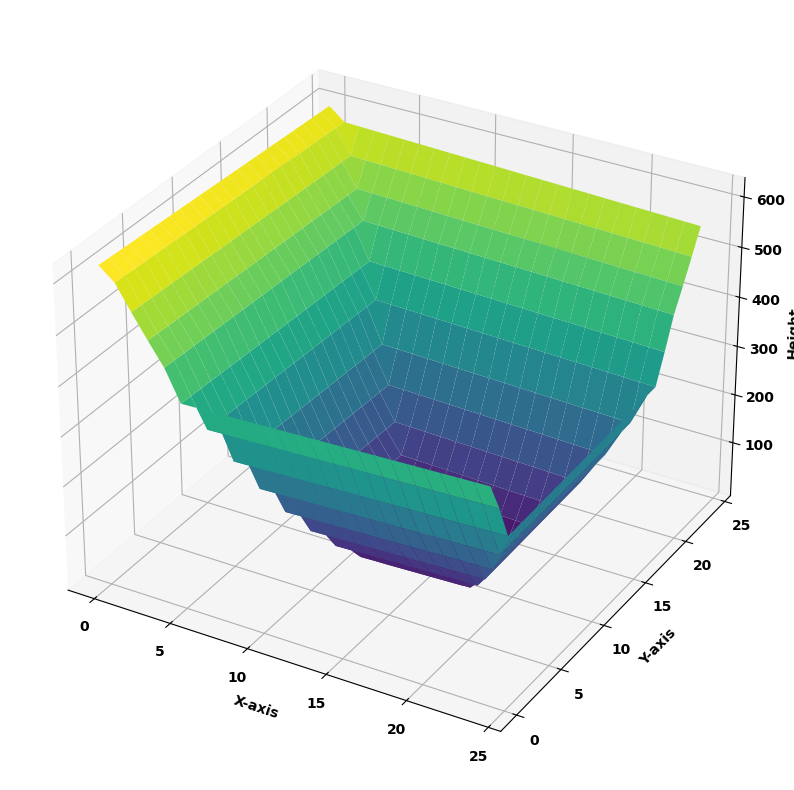

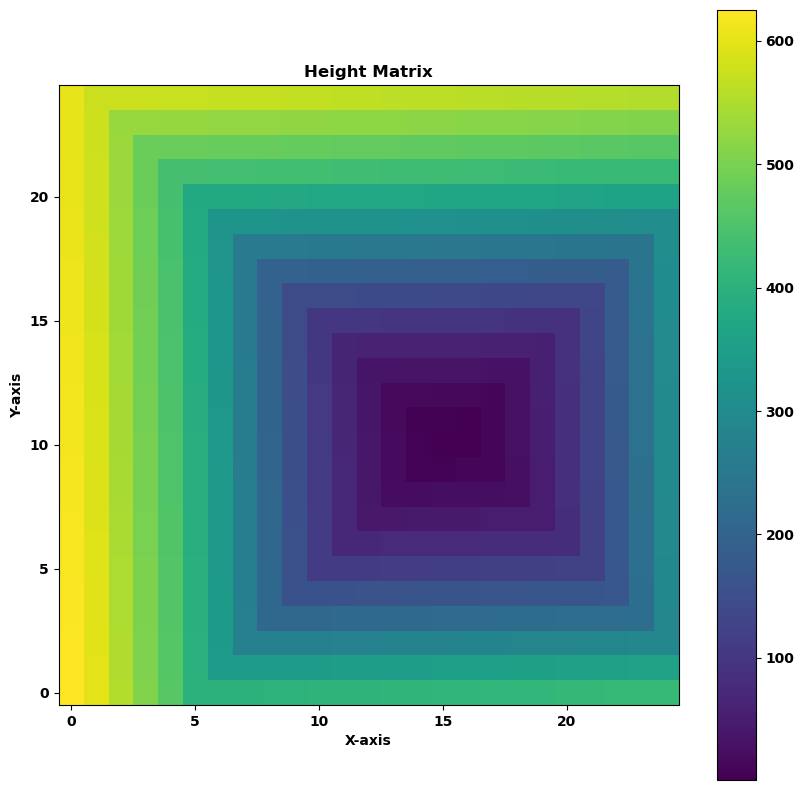

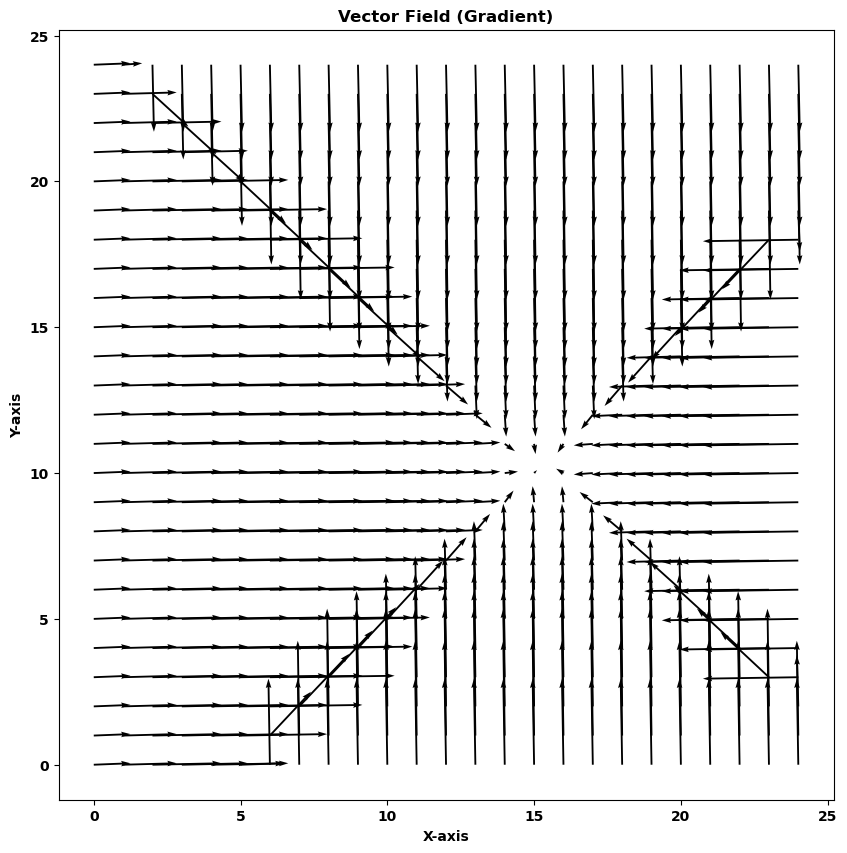

In [9]:
display_solution(matrix_1)

# Solution 2 (BFS add numbers to grid but not bounded by the grid)
Imagine the grid as a display like a monitor, the spiral is not dependent on your monitor's view to graph the correct values.
It's like in a video game where you can see half of an object because the other half is off screen and you know that the object is not messed up even when you can only see the visible part.

In [10]:
grid_recordable_2 = GridRecordable((grid_size_x, grid_size_y))

number_of_valid_positions_on_grid = grid_size_x * grid_size_y

bfs_spiral_add_numbers_to_grid_unbounded(
    grid_recordable_2, 
    number_of_valid_positions_on_grid, 
    position_center_absolute, 
    list_cycle_position_shift
)

matrix_2 = np.array(grid_recordable_2)
print(matrix_2)

[[926 809 700 599 506 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440]
 [925 808 699 598 505 420 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361]
 [924 807 698 597 504 419 342 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290]
 [923 806 697 596 503 418 341 272 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 291]
 [922 805 696 595 502 417 340 271 210 157 158 159 160 161 162 163 164 165 166 167 168 169 170 227 292]
 [921 804 695 594 501 416 339 270 209 156 111 112 113 114 115 116 117 118 119 120 121 122 171 228 293]
 [920 803 694 593 500 415 338 269 208 155 110  73  74  75  76  77  78  79  80  81  82 123 172 229 294]
 [919 802 693 592 499 414 337 268 207 154 109  72  43  44  45  46  47  48  49  50  83 124 173 230 295]
 [918 801 692 591 498 413 336 267 206 153 108  71  42  21  22  23  24  25  26  51  84 125 174 231 296]
 [917 800 691 590 497 412 335 266 205 152 107  70  41  20   7   8   9  10

In [11]:
list_matrix_2 = grid_recordable_2.get_list_matrix_recorded()
list_matrix_2 = list_matrix_2  # Leave this here for debugging via slicing

STR_PATH_FILENAME_SOLUTION_2 = str(Path(PATH_DIRETORY_MEIDA_OUTPUT_ABSOLUTE, "solution_2.gif"))

animation_2 = get_animation_of_matrix_changes(
    list_matrix_2,
    STR_PATH_FILENAME_SOLUTION_2,  
)

media\solution_2.gif already exists! No file saved!


In [12]:
# IF THIS IS DISPLAYED AND THIS FILE IS SAVED, THEN THE FILESIZE OF THIS WILL BE MASSIVE.
# HTML(animation_2.to_jshtml())

In [13]:
# Image(STR_PATH_FILENAME_SOLUTION_2)  # This style does not display on GitHub

# Display the image in Markdown
display(Markdown(f"![{STR_PATH_FILENAME_SOLUTION_2}]({STR_PATH_FILENAME_SOLUTION_2})"))

![media\solution_2.gif](media\solution_2.gif)

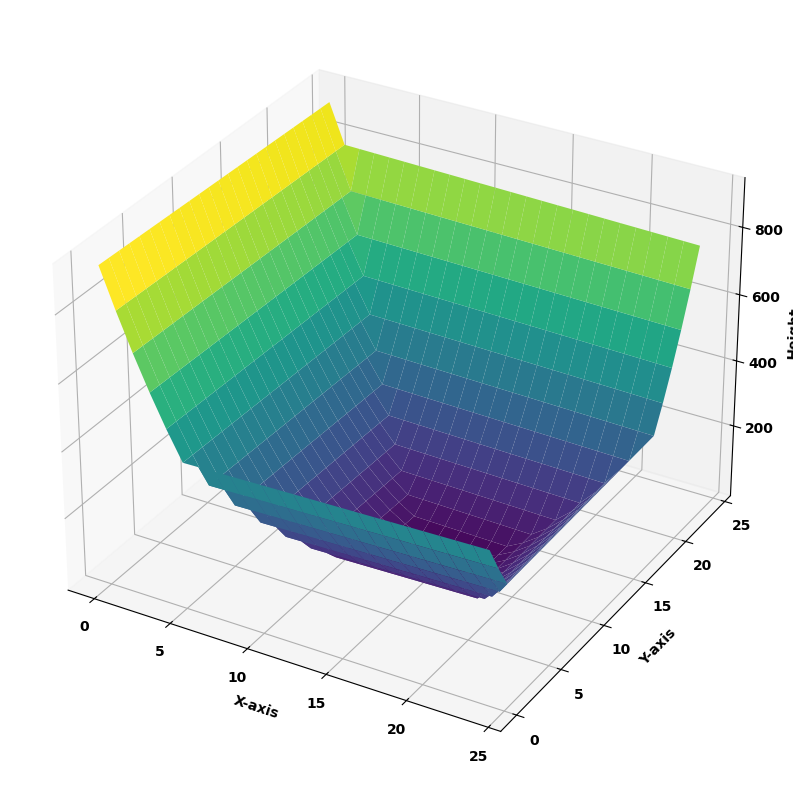

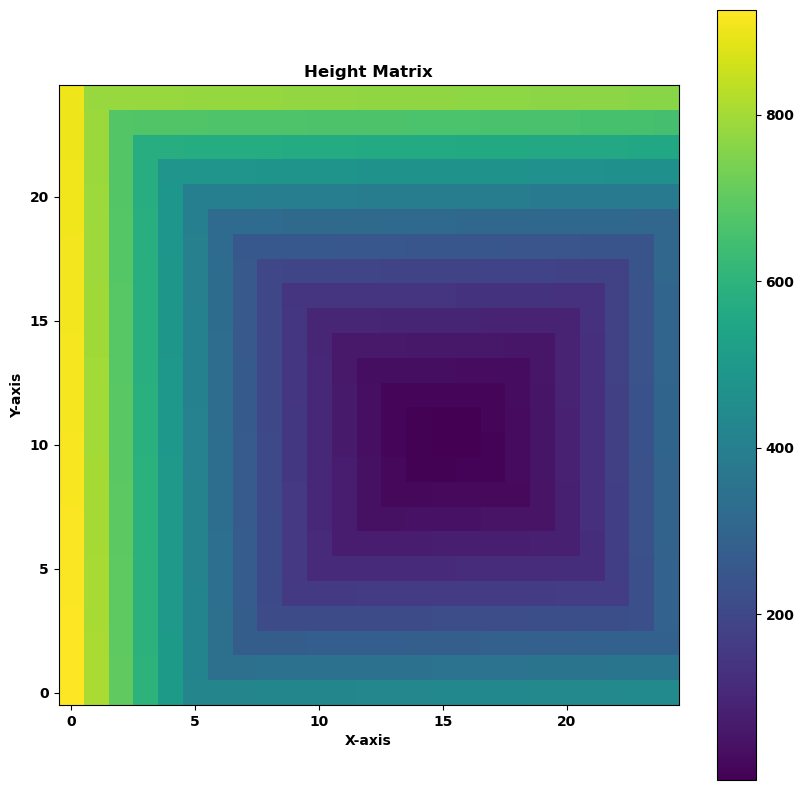

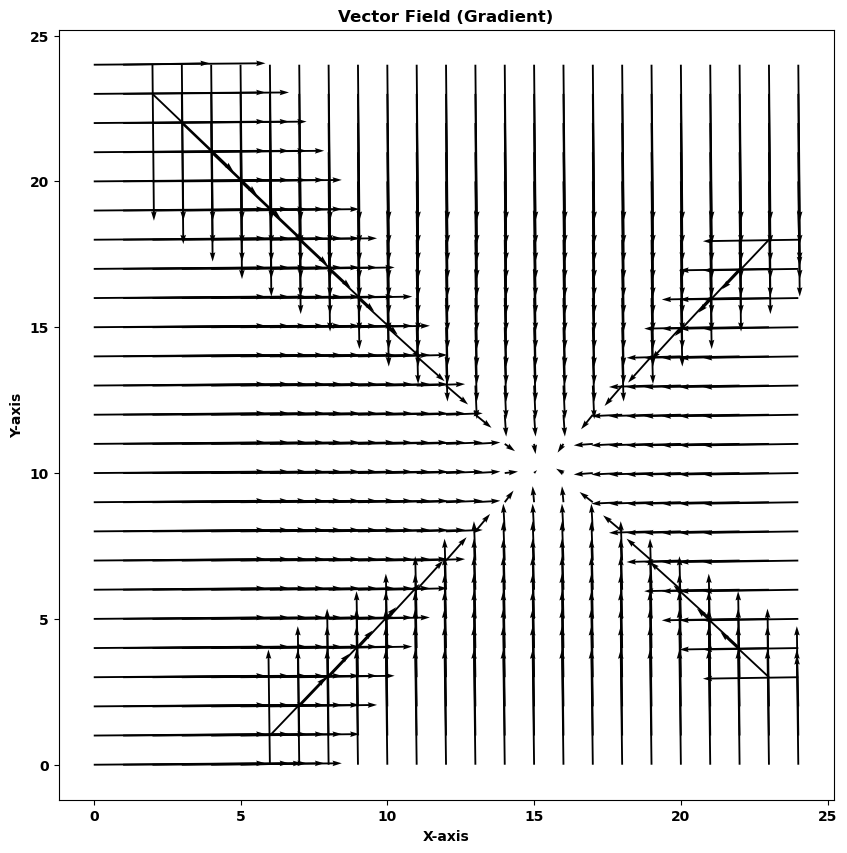

In [14]:
display_solution(matrix_2)

# Solution 3 (Mathematically and logically calculate the value of any given cell given the spiral center position)
![https://en.meming.world/images/en/1/18/Giga_Chad.jpg](media/gigachad.jpg)

In [15]:
grid_recordable_3 = GridRecordable((grid_size_x, grid_size_y))

math_solution_add_numbers_to_grid_independent_of_grid(
    grid_recordable_3, 
    position_center_absolute,
)
    
matrix_test_1 = np.array(grid_recordable_3)
print(matrix_test_1)

[[926 809 700 599 506 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440]
 [925 808 699 598 505 420 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361]
 [924 807 698 597 504 419 342 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290]
 [923 806 697 596 503 418 341 272 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 291]
 [922 805 696 595 502 417 340 271 210 157 158 159 160 161 162 163 164 165 166 167 168 169 170 227 292]
 [921 804 695 594 501 416 339 270 209 156 111 112 113 114 115 116 117 118 119 120 121 122 171 228 293]
 [920 803 694 593 500 415 338 269 208 155 110  73  74  75  76  77  78  79  80  81  82 123 172 229 294]
 [919 802 693 592 499 414 337 268 207 154 109  72  43  44  45  46  47  48  49  50  83 124 173 230 295]
 [918 801 692 591 498 413 336 267 206 153 108  71  42  21  22  23  24  25  26  51  84 125 174 231 296]
 [917 800 691 590 497 412 335 266 205 152 107  70  41  20   7   8   9  10

In [16]:
list_matrix_3 = grid_recordable_3.get_list_matrix_recorded()
list_matrix_3 = list_matrix_3  # Leave this here for debugging via slicing

STR_PATH_FILENAME_SOLUTION_3 = str(Path(PATH_DIRETORY_MEIDA_OUTPUT_ABSOLUTE, "solution_3.gif"))

animation_3 = get_animation_of_matrix_changes(
    list_matrix_3,
    STR_PATH_FILENAME_SOLUTION_3,  
)

media\solution_3.gif already exists! No file saved!


In [17]:
# IF THIS IS DISPLAYED AND THIS FILE IS SAVED, THEN THE FILESIZE OF THIS WILL BE MASSIVE.
# HTML(animation_3.to_jshtml())

In [18]:
# Image(STR_PATH_FILENAME_SOLUTION_3)  # This style does not display on GitHub

# Display the image in Markdown
display(Markdown(f"![{STR_PATH_FILENAME_SOLUTION_3}]({STR_PATH_FILENAME_SOLUTION_3})"))

![media\solution_3.gif](media\solution_3.gif)

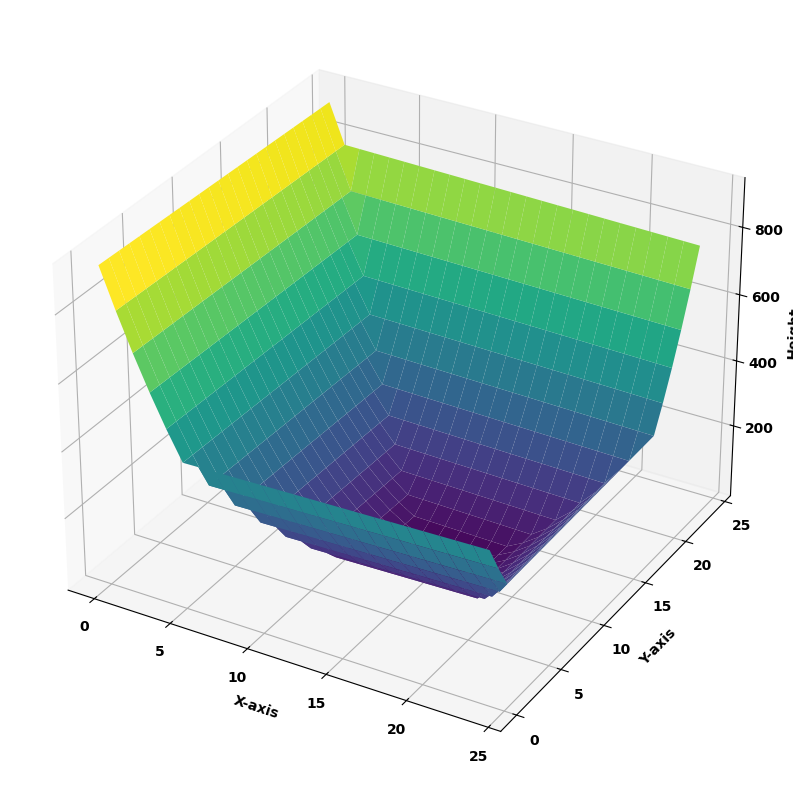

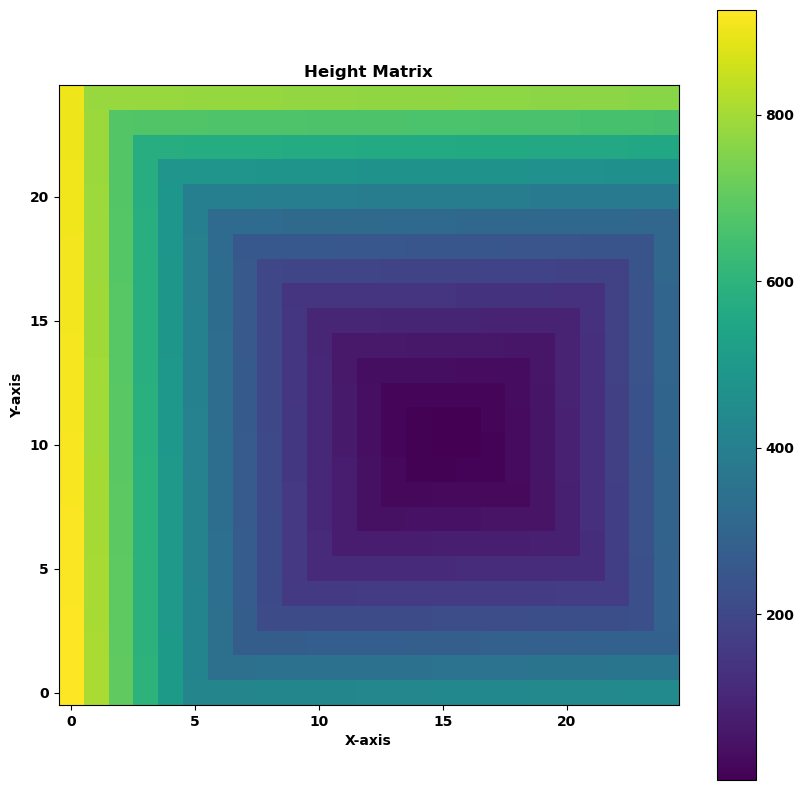

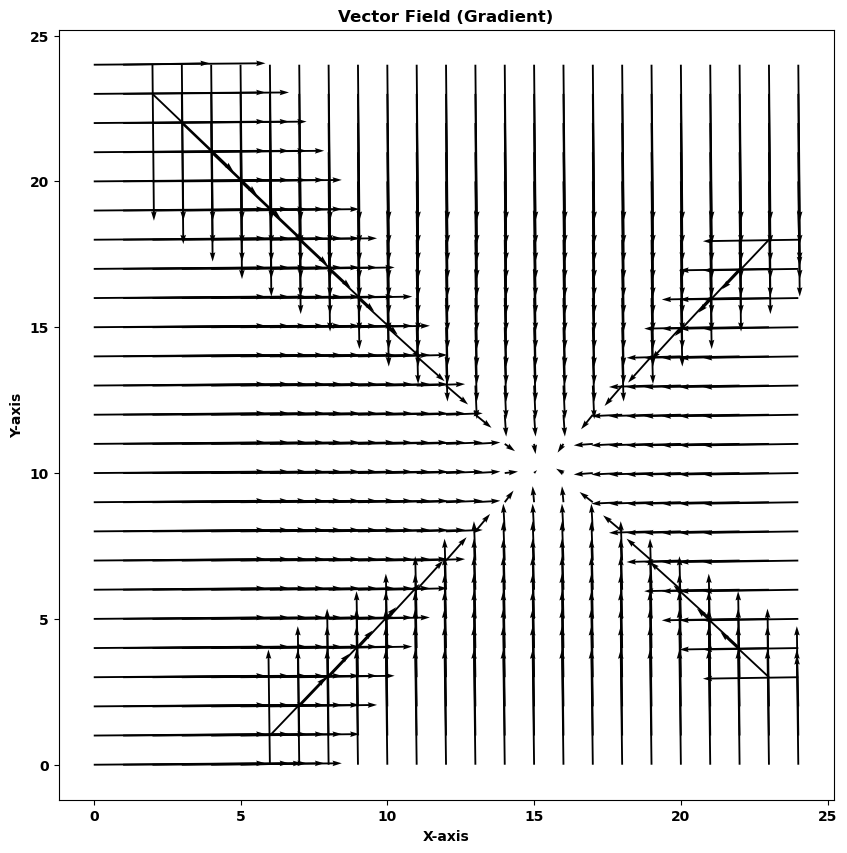

In [19]:
display_solution(matrix_test_1)

# Testing Zone (Ignore)

In [20]:
list_cycle_position_shift_custom = [
    (0, -1),  # Up
    (0, 1),  # Down
    (1, 0),  # Right
    (-1, 0),  # Left
    (1, -1),  # Up Right
    (-1, 1),  # Down Left
    (-1, -1),  # Up Left
    (1, 1),  # Down Right
]


In [21]:
# grid_test_1 = get_grid(grid_size_x, grid_size_y)

# bfs_spiral_add_numbers_to_grid_bounded(
#     grid_test_1, 
#     position_center_absolute, 
#     list_cycle_position_shift_custom
# )

# matrix_test_1 = np.array(grid_test_1)
# display_solution((matrix_test_1))

In [22]:
# grid_test_2 = get_grid(grid_size_x, grid_size_y)

# _number_of_valid_positions_on_grid = grid_size_x * grid_size_y

# bfs_spiral_add_numbers_to_grid_unbounded(
#     grid_test_2, 
#     _number_of_valid_positions_on_grid, 
#     position_center_absolute, 
#     list_cycle_position_shift_custom
# )

# (matrix_test_2) = np.array(grid_test_2)
# display_solution(((matrix_test_2)))
